In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
%matplotlib inline

We'll start out by going through the same data cleaning steps outlined in ProPublica's methodology.

In [2]:
raw = pd.read_csv('data/compas-scores-two-years.csv')
d = raw[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 
         'juv_fel_count','juv_misd_count','juv_other_count',
                    'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']]
d = d[(d.days_b_screening_arrest >= -30) & 
      (d.days_b_screening_arrest <= 30) & 
      (d.is_recid != -1) & 
      (d.c_charge_degree != 'O') & 
      (d.score_text != 'N/A')]
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6172 entries, 0 to 7213
Data columns (total 16 columns):
age                        6172 non-null int64
c_charge_degree            6172 non-null object
race                       6172 non-null object
age_cat                    6172 non-null object
score_text                 6172 non-null object
sex                        6172 non-null object
priors_count               6172 non-null int64
juv_fel_count              6172 non-null int64
juv_misd_count             6172 non-null int64
juv_other_count            6172 non-null int64
days_b_screening_arrest    6172 non-null float64
decile_score               6172 non-null int64
is_recid                   6172 non-null int64
two_year_recid             6172 non-null int64
c_jail_in                  6172 non-null object
c_jail_out                 6172 non-null object
dtypes: float64(1), int64(8), object(7)
memory usage: 819.7+ KB


The ProPublica analysis was focused on trying to predict `decile_score` and `score_text`, in order to see to what extent those variables could be predicted by race. I'll see to what extent I can do the same thing using yellowbrick and scikit-learn.

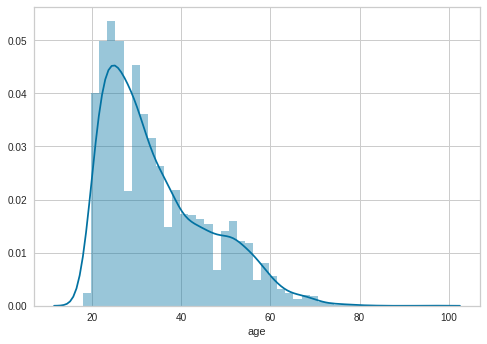

In [5]:
# Try with Seaborn instead
import seaborn as sns
sns.distplot(X_df.age)

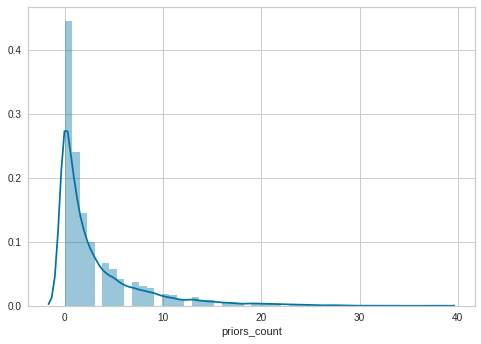

In [6]:
sns.distplot(X_df.priors_count)

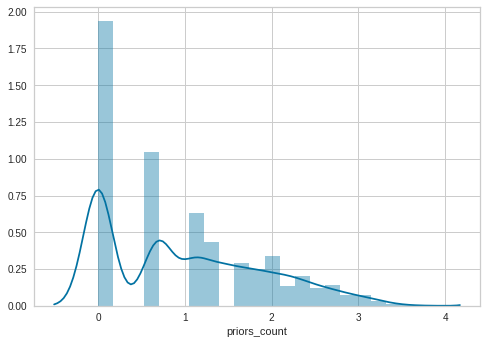

In [7]:
sns.distplot(np.log1p(X_df.priors_count))

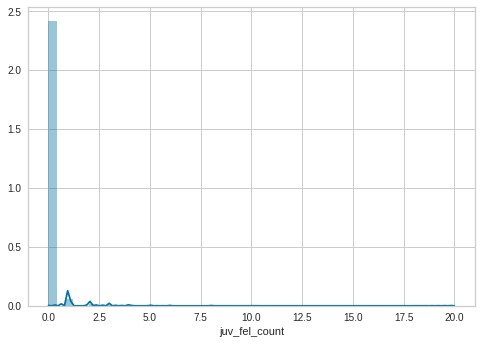

In [8]:
sns.distplot(X_df.juv_fel_count)

So... the vast majority of people in this dataset do not have any juvenile convictions. I can balance things out a little by log-transforming my count variables.

In [4]:
#X_df = pd.get_dummies(d[['age','sex','race','c_charge_degree','priors_count','juv_fel_count','juv_misd_count',
#                         'juv_other_count']]).drop(['sex_Female','c_charge_degree_M'],axis='columns')
X_df = pd.get_dummies(d[['age','sex','race','c_charge_degree','priors_count',
                         'two_year_recid']]).drop(['sex_Female','c_charge_degree_M'],axis='columns')
X_df.priors_count = np.log1p(X_df.priors_count)
#X_df.juv_fel_count = np.log1p(X_df.juv_fel_count)
#X_df.juv_misd_count = np.log1p(X_df.juv_misd_count)
#X_df.juv_other_count = np.log1p(X_df.juv_other_count)

X = X_df.as_matrix()
#y = d.two_year_recid.as_matrix()
y = d.score_text.replace({'Low':0,'Medium':1,'High':2}).as_matrix()

In [17]:
X_df.columns

Index(['age', 'priors_count', 'two_year_recid', 'sex_Male',
       'race_African-American', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Native American', 'race_Other',
       'c_charge_degree_F'],
      dtype='object')

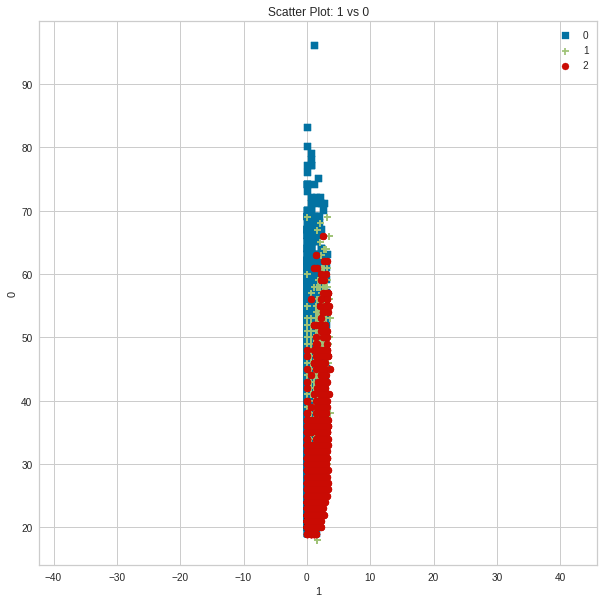

In [20]:
from yellowbrick.features import ScatterVisualizer
scat1 = ScatterVisualizer(x=1,y=0)
scat1.fit(X,y)
scat1.transform(X)
scat1.poof()
## Not sure why this doesn't work

WTF? Try JointPlotVisualizer instead.

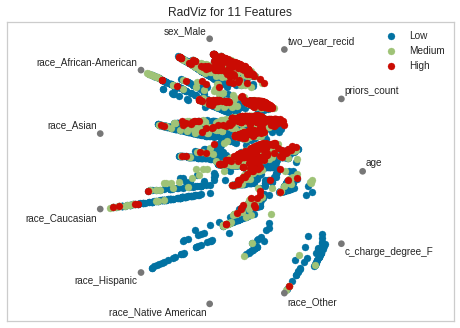

In [6]:
from yellowbrick.features import RadViz
from yellowbrick.style.palettes import color_palette

#visualizer = RadViz(classes=['Low','Medium','High'], features=list(X_df.columns),palette=color_palette('Spectral'))
visualizer = RadViz(classes=['Low','Medium','High'], features=list(X_df.columns))
visualizer.fit(X, y)    
visualizer.transform(X)  
matplotlib.rcParams['figure.figsize'] = [8,8]
visualizer.poof()       

If I use (almost) the exact same set of features that was used in the COMPAS analysis, I get a rough separation of the low and high-risk predictions. This visualization might look better if I reorder columns so that the ones that correlate well are placed close together.

/home/craig/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:1310: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


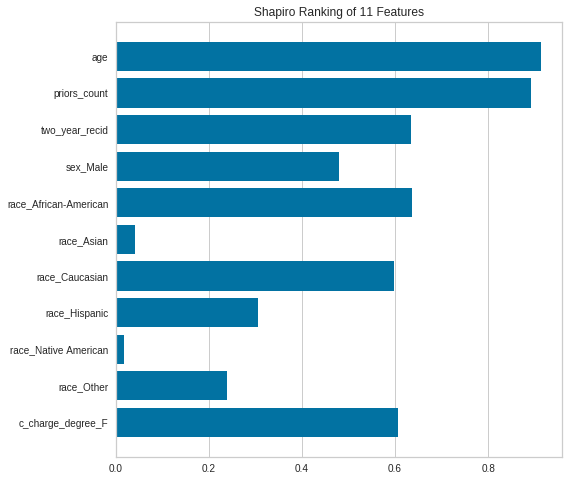

In [7]:
from yellowbrick.features import Rank1D, Rank2D

visualizer = Rank1D(features=list(X_df.columns), algorithm='shapiro')

visualizer.fit(X, y)                # Fit the data to the visualizer
visualizer.transform(X)             # Transform the data
visualizer.poof() 

This is just a test of normality, right? It doesn't look like y is really doing anything here.

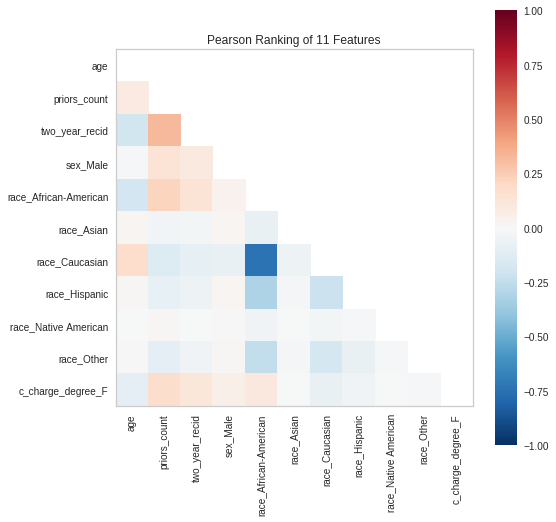

In [8]:
visualizer = Rank2D(features=list(X_df.columns), algorithm='pearson')

visualizer.fit(X, y)                # Fit the data to the visualizer
visualizer.transform(X)             # Transform the data
visualizer.poof() 

TODO: Add numeric risk rating to this one.

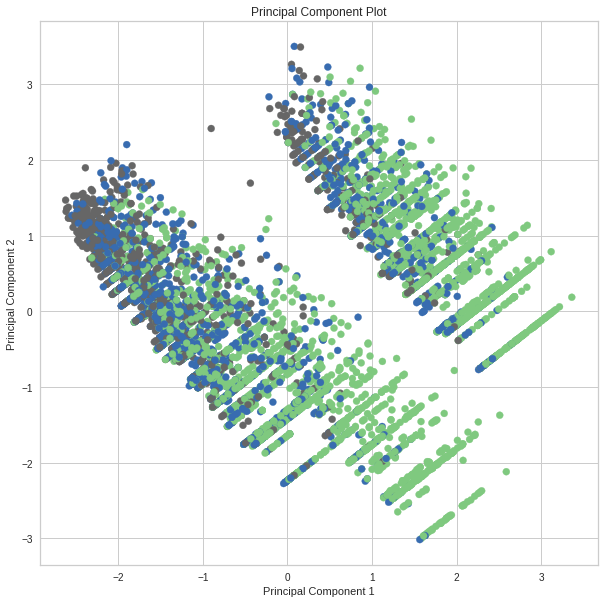

No handles with labels found to put in legend.


In [30]:
from yellowbrick.features.pca import PCADecomposition

visualizer = PCADecomposition(scale=True, center=True,color=y,colormap='Accent') 
visualizer.fit_transform(X,y)
matplotlib.rcParams['figure.figsize'] = [10,10]
visualizer.poof()


There seems to be separation into two big clusters, but it's hard to tell what defines them. Also, the default colors aren't great.

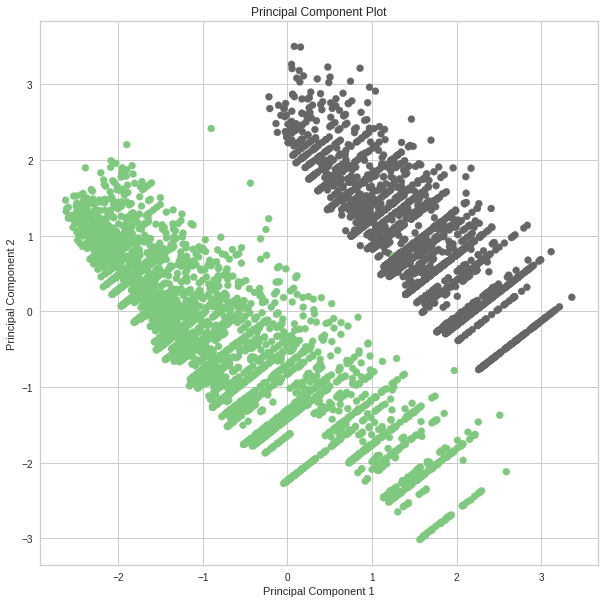

In [27]:
from yellowbrick.style.palettes import color_palette

y2 = (d.race == 'Caucasian').as_matrix()
visualizer = PCADecomposition(scale=True, center=True, color=y2,colormap='Accent')
visualizer.fit_transform(X,y)
matplotlib.rcParams['figure.figsize'] = [10,10]
visualizer.poof()

So yes, the clusters are about race.

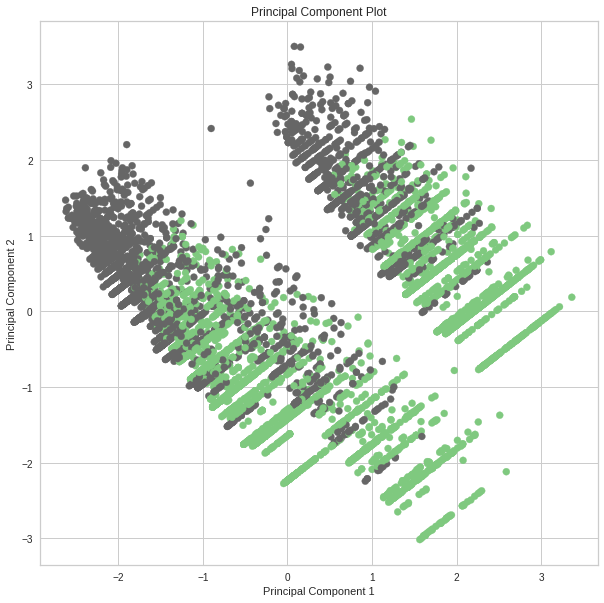

In [33]:
y3 = d.two_year_recid.as_matrix()
visualizer = PCADecomposition(scale=True, center=True, color=y3,colormap='Accent')
visualizer.fit_transform(X,y)
matplotlib.rcParams['figure.figsize'] = [10,10]
visualizer.poof()

Scatterplot risk score against two_year_recid, color-code by race. Or maybe do small multiples. Able to get transparent dots using alpha? Would need jitter.